**Due date is Wednesday, April 7, 2021, 23:59 PST**

**ONLY write into the existing cells, and do NOT delete or add any cells.**


# ELEC 400M / EECE 571M Assignment 3: Clustering
(Again, this assignment drew inspiration from an assignment used in ECE 421 at the University of Toronto and kindly made available to us by the instructor; as well as from the problem set in our textbook Learning from Data.)

In this assignment, you will implement and test methods for clustering that we have discussed in the course.

## Data Sets

You will be working with two data sets:
- data2D.npy
- data100D.npy

Each of the data sets has 10,000 data points, which are 2-dimensional and 100-dimensional, respectively.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


## K-Means algorithm [18 marks]

You will first implement and test the K-means algorithm. 

For this, you will **only use functions from the NumPy library**. 

### Implement the functions [5 marks]

You will implement four functions to realize the K-Means algorithm.

- `distanceFunc`: This function accepts your data and cluster centers and returns the squared pairwise distances between data points and cluster centers. 
- `KMinit`: This function accepts your data and returns the initial cluster centres. You will use the "greedy approach" described on page 6-16 in the textbook, but instead of a randomly selected data point always pick the first entry in the data set as the first center. 
- `lossFunc`: This function accepts the squared pairwise distances between data points and cluster centers and returns the error measure as defined in (6.5) in the textbook. 
- `KMmeans`: This function implements the K-Means algorithm as described in the textbook. It returns the cluster centers and the error measure as defined in (6.5) in the textbook. 

In [3]:
def distanceFunc(x, mu):
    # Inputs  
    # x: is an NxD data matrix (N observations and D dimensions)
    # mu: is an KxD cluster center matrix (K cluster centers and D dimensions)
    # Output
    # pair_dist2: is the NxK matrix of squared pairwise distances
    
    # YOUR CODE HERE 
    # initialize row and column indices for pair_dist2
    row_nums = range(0, x.shape[0])
    col_nums = range(0, mu.shape[0])
    row_inds, col_inds = np.meshgrid(row_nums, col_nums, indexing='ij')
    
    # compute |x- mu|^2 with vectorization
    xSubMu = x[row_inds] - mu[col_inds]
    pair_dist = np.linalg.norm(xSubMu, axis=2)
    pair_dist2 = np.square(pair_dist)
    return pair_dist2

In [4]:
def computeDistToCluster(x, x_row, picked_rows):
    # Inputs
    # x: NxD data matrix
    # x_row: row of a cluster center candidate
    # picked_rows: list of rows picked as cluster centers
    # Ouput
    # distance from center candidate to picked centers
    assert x_row not in picked_rows
    
    clusters = x[picked_rows, :] # (len(picked_rows), D)
    candidate = x[x_row, :] # (D, )
    
    min_dist = -1
    for row in range(0, clusters.shape[0]):
        dist = np.linalg.norm(candidate - clusters[row, :])
        if min_dist == -1 or dist < min_dist:
            min_dist = dist
    
    return min_dist


def KMinit(x, K):
    # Inputs
    # x: is an NxD data matrix 
    # K: number of clusters
    # Output
    # mu: is the KxD matrix of initial cluster centers using the "greedy approach" described on page 6-16 in the textbook. 
    # Remark: Always pick the first entry in the data set as the first center. 
    
    # YOUR CODE HERE
    # initialize mu
    mu = np.zeros((K, x.shape[1]))
    
    # pick the first center
    mu[0, :] = x[0, :]
    picked_rows = [0] # list of rows in X picked as center
    
    # iteratively assign new cluster centers
    assert K <= x.shape[0]
    for mu_row in range(1, K):
        row_selected = -1
        max_dist = -1
        # for each of the rest of points
        for x_row in range(0, x.shape[0]):
            if x_row not in picked_rows:
                # compute distance to set of picked centers
                dist = computeDistToCluster(x, x_row, picked_rows)
                # pick the point with min distance as the new center
                if dist > max_dist:
                    row_selected = x_row
                    max_dist = dist
        mu[mu_row, :] = x[row_selected, :]
        picked_rows.append(row_selected)
    
    return mu

In [5]:
def lossFunc(pair_dist2):
    # Input 
    # pair_dist2: is an NxK matrix of squared pairwise distances
    # Output
    # loss: error as defined in (6.5) in the textbook
    
    # YOUR CODE HERE
    dist2_to_centers = np.amin(pair_dist2, axis=1)
    loss = np.sum(dist2_to_centers)
    return loss

In [6]:
def computeCentroids(x, cluster_assigned):
    # Inputs
    # x: is an NxD data matrix
    # cluster_assigned: (N, ) array of cluster index
    # Outputs
    # mu: is the KxD of cluster centers
    K = np.amax(cluster_assigned) + 1
    mu = np.zeros((K, x.shape[1]))
    for cluster_index in range(0, K):
        x_in_cluster = x[cluster_assigned==cluster_index, :]
        mu[cluster_index, :] = np.mean(x_in_cluster, axis=0)
    return mu

def Kmeans(x,K):
    # Inputs
    # x: is an NxD data matrix 
    # K: number of clusters
    # Outputs
    # mu: is the KxD of cluster centers  
    # loss: error as defined in (6.5) in the textbook 
    
    # YOUR CODE HERE
    # initialize mu and loss
    mu = KMinit(x, K)
    loss_last = -1.0
    loss_curr = lossFunc(distanceFunc(x, mu))
    
    # until loss stops decreasing
    while loss_last == -1.0 or abs(loss_curr - loss_last)>1e-9:
        # update last loss
        if loss_curr != -1.0:
            loss_last = loss_curr
        # cluster on mu
        pair_dist2_before = distanceFunc(x, mu)
        cluster_assigned = np.argmin(pair_dist2_before, axis=1) # (N, )
        # update mu
        mu = computeCentroids(x, cluster_assigned)
        assert mu.shape[0] == K
        # compute loss
        pair_dist2_after = distanceFunc(x, mu)
        loss_curr = lossFunc(pair_dist2_after)
    
    return mu, loss_curr

### Test the functions [5 marks]

Develop toy-sized test cases (create your own very small data set(s)) for all four functions and verify the correct operation. 

Use the code cell below to program the test cases and to print and/or plot the results as appropriate. 

Use the text cell below to describe your test cases, to show the results and plots from your code, and to comment on the results. 

In [7]:
# YOUR CODE HERE
from matplotlib.lines import Line2D

def visualizeClusters(x, mu, title, legend_loc, filename, cluster_assigned=None, centroid_coloring='diff', plot_lines=True):
    # Visualize clusters. Support at most 6 clusters.
    # Implementation derived from visualization example from
    # https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489
    # Inputs
    # x: Nx2 data matrix
    # mu: Kx2 cluster centers
    # title: plot title
    # legend_loc: location of legend in figure
    # filename: path to save figure
    # cluster_assigned: (N, ) array of cluster assignments, optional
    # centroid_coloring: 'same' or 'diff', optional
    # plot_lines: if plot lines to connect point to centroid or not, optional
    
    # plot x and mu
    fig = plt.figure(figsize=(8,8))
    if cluster_assigned is None:
        cluster_assigned = np.argmin(distanceFunc(x, mu), axis=1) # (N, )
    K = mu.shape[0]
    assert K <= 6
    colors = ['blue', 'forestgreen', 'red', 'deepskyblue', 'sandybrown', 'turquoise']
    for cluster_index in range(0, K):
        x_in_cluster = x[cluster_assigned==cluster_index, :]
        plt.scatter(x_in_cluster[:, 0], x_in_cluster[:, 1], c=colors[cluster_index], alpha=0.6, s=10, label=f"Cluster {cluster_index}")
        centroid_color = colors[cluster_index]
        if centroid_coloring == 'same':
            centroid_color = 'black'
        plt.scatter(mu[cluster_index, 0], mu[cluster_index, 1], marker='*', c=centroid_color, s=70, label=f"Cluster centroid {cluster_index}")
    
    # plot lines
    if plot_lines:
        for cluster_index in range(0, K):
            x_in_cluster = x[cluster_assigned==cluster_index, :]
            for row in range(0, x_in_cluster.shape[0]):
                x1 = [x_in_cluster[row, 0], mu[cluster_index, 0]]
                x2 = [x_in_cluster[row, 1], mu[cluster_index, 1]]
                plt.plot(x1, x2, c=colors[cluster_index], alpha=0.2)
            
    # add legends, axis labels, title
    plt.legend(loc=legend_loc, ncol=2)
    
    # add title and labels
    plt.title(f'{title}\n')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    # save figure
    plt.savefig(filename)
    
    plt.close(fig)

# tests for distanceFunc
x = np.array([[2.5, 3.1], [4.1, 7.6], [0.8, 1.7]])
mu = np.array([[0.2, 1.5], [3.5, 6.0]])
dist2_expected = np.array([[7.85, 9.41], [52.42, 2.92], [0.4, 25.78]])
dist2 = distanceFunc(x, mu)
assert dist2.shape == dist2_expected.shape
assert np.linalg.norm(dist2 - dist2_expected) < 1e-2
visualizeClusters(x=x, mu=mu, title='distanceFunc()', legend_loc='upper left', filename='test_distanceFunc.png')

# tests for KMInit
X = np.array([[1.4, 2.3], [1.5, 2.0], [2.5, -1.0], [2.0, -0.5], [1.0, -1.0]])
K = 3
centers_expected = np.array([[1.4, 2.3], [2.5, -1.0], [1.0, -1.0]])
centers = KMinit(X, K)
assert np.linalg.norm(centers - centers_expected) < 1e-9
visualizeClusters(x=X, mu=centers, title='KMInit()', legend_loc='upper right', filename='test_KMInit.png')

# tests for lossFunc
dist2_expected = np.array([[7.85, 9.41], [52.42, 2.92], [0.4, 25.78]])
loss_expected = 7.85 + 2.92 + 0.4
loss = lossFunc(dist2_expected)
assert np.linalg.norm(loss - loss_expected) < 1e-9

# tests for Kmeans
# test case: 8 points, 2 clusters
x = np.array([[-3, 2], [-2, 1], [2, -1], [3, -1], [-2, 2], [2, -2], [-3, 1], [3, -2]], dtype=np.float64)
K = 2
mu, loss = Kmeans(x, K)
mu_expected = np.array([[-2.5, 1.5], [2.5, -1.5]])
loss_expected = 4.0
assert np.linalg.norm(mu - mu_expected)<1e-9 and np.linalg.norm(loss - loss_expected)<1e-9
visualizeClusters(x=x, mu=mu, title='Kmeans, 8 points', legend_loc='upper right', filename='test_Kmeans_8pts.png')
# test case: 1 point, 1 cluster
x = np.array([[0.5, 0.5]])
K = 1
mu, loss = Kmeans(x, K)
mu_expected = np.array([[0.5, 0.5]])
loss_expected = 0.0
assert np.linalg.norm(mu - mu_expected)<1e-9 and np.linalg.norm(loss - loss_expected)<1e-9
visualizeClusters(x=x, mu=mu, title='Kmeans, 1 point', legend_loc='upper right', filename='test_Kmeans_1pt.png')

1. **Tests for `distanceFunc()`.** Here we construct a test case where $x$ as a $3 \times 2$ data matrix:
$$x = \begin{bmatrix}
2.5 & 3.1\\ 
4.1 & 7.6\\ 
0.8 & 1.7
\end{bmatrix},$$
and $\mu$ as a $2 \times 2$ matrix denoting two clusters:
$$\mu = \begin{bmatrix}
0.2 & 1.5\\ 
3.2 & 6.0
\end{bmatrix}.$$
The pairwise squared distance matrix expected is a $3 \times 2$ matrix:
$$dist^{2}_{expected} = \begin{bmatrix}
7.85 & 9.41\\ 
52.42 & 2.92\\ 
0.4 & 25.78
\end{bmatrix}.$$
The output from `distanceFunc()` is indeed the expected matrix. The diagram visualizes the points and the cluster centroids: ![](test_distanceFunc.png)

2. **Tests for `KMInit()`.** Here we construct a test case with 5 2D points that are obvious in terms of how they should be clustered:
$$x = \begin{bmatrix}
1.4 & 2.3\\ 
2.5 & 2.0\\ 
2.5 & -1.0\\
2.0 & -0.5\\
1.0 & -1.0
\end{bmatrix},$$ and we set $K=3$ for 3 clusters. The expected cluster centroids from `KMInit()` are $(1.4, 2.3)$, $(2.5, -1.0)$ and $(1.0, -1.0)$. From the assertion statement and the visualized clusters we can see our implementation can produce the correct result: ![](test_KMInit.png)

3. **Tests for `lossFunc()`.** Here we construct a test case for which we reuse the pairwise squared distance matrix $dist^{2}_{expected}$ from the test for `distanceFunc()`. We know for each sample (row) its centroid is the one which yields the least squared distance. Thus the error as defined in (6.5) in the textbook is the sum of minimum distances along each row - $7.85+2.92+0.4$. The output from `lossFunc()` is as we expected.

4. **Tests for `Kmeans()`.** Here we construct two test cases: 1) 8 samples that can be easily partitioned into two clusters:
$$x = \begin{bmatrix}
-3 & 2\\ 
-2 & 1\\ 
2 & -1\\
3 & -1\\
-2 & 2\\
2 & -2\\
-3 & 1\\
3 & -2\\
\end{bmatrix}.$$ The expected loss is $4$, and the assertion statement tells us `Kmeans()` can produce the correct loss. Also, from the visualization we can see Kmeans() can produce the correct centroids and clustering: ![](test_Kmeans_8pts.png)
2) One sample. The loss should be trivially $0$ and the centroid should be itself. The assertion tells us `Kmeans()` got the loss right. Also we can see from the visualization the centroid and clustering are correct: ![](test_Kmeans_1pt.png)

### Run K-Means on 2D data set [4 marks]

Implement a script that runs the K-Means algorithm using the functions above and run it for the data set data2D.npy with $K = 1, 2, 3, 4, 5$.  

The script should produce the following plots:
- for each of these values of $K$, a 2D scatter plot of the data points colored by their cluster assignments plus the cluster centers
- the K-means loss as a function of $K$

Show the plots in the text cell below and discuss how many clusters you think are "best" and why.

Cluster at K=1
Cluster at K=2
Cluster at K=3
Cluster at K=4
Cluster at K=5


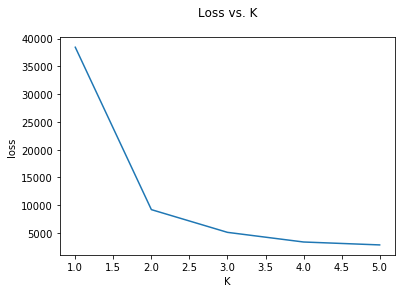

In [8]:
# YOUR CODE HERE
x = np.load('data2D.npy')
losses_data2D = []

# plot clusters
for K in range(1, 6):
    print(f'Cluster at K={K}')
    mu, loss = Kmeans(x, K)
    visualizeClusters(x=x, mu=mu, title=f'K={K}, loss={loss:.2f}', legend_loc='upper right', filename=(f'data2D_K={K}.png'), centroid_coloring='same', plot_lines=False)
    losses_data2D.append(loss)

# plot loss vs. K
fig = plt.figure()
plt.plot(range(1, 6), losses_data2D)
plt.title('Loss vs. K\n')
plt.xlabel('K')
plt.ylabel('loss')
plt.savefig('data2D_loss_vs_K.png')

Here we present the visualized clustering results:
1. **The centroid is marked in black. You can find it by looking closely at the center of the image.**
![](data2D_K=1.png)
2. **The centroids are marked in black. You can find them by looking closely.**
![](data2D_K=2.png)
3. **The centroids are marked in black. You can find them by looking closely.**
![](data2D_K=3.png)
4. **The centroids are marked in black. You can find them by looking closely.**
![](data2D_K=4.png)
5. **The centroids are marked in black. You can find them by looking closely.**
![](data2D_K=5.png)

Here we present the loss vs. K graph:
6. ![](data2D_loss_vs_K.png)
7. **$K=3$ is the best.** We select $K$ using the elbow method: looking at the loss vs. K graph, we see loss drops rapidly from $K=1$ to $K=2$, but not as much from $K=2$ to $K=3$. So $3$ is the elbow of the graph. Also by observing the scatter plots of our data, we can identify two small blobs (one at lower left, one at upper right) and one large blob in the middle. So we consider $3$ being the best value for $K$.

### Explore Gap statistic [4 marks]

Implement a script which does the following using the functions implemented above.

Generate benchmark random data of the same size as the 2D data set, distributed uniformly over the smallest axis-aligned rectangle containing the actual data. Run the K-Means algorithm on this random data for $K=1,2,3,4,5$. 

Repeat for 10 such random data sets to obtain the average of the log-K-Means errors, $$\mathrm{LE}_{\mathrm{in}}^{\mathrm{rand}}(K)=\frac{1}{10}\sum\limits_{i=1}^{10}\log\left(E_{\mathrm{in},i}^{\mathrm{rand}}(K)\right)$$ as a function of $K$. 

Plot the average K-Means error and the gap statistic 
$$G(K)=\mathrm{LE}_{\mathrm{in}}^{\mathrm{rand}}(K)-\log \left[E_{\mathrm{in}}(K)\right]$$
as functions of $K$, where $E_{\mathrm{in}}(K)$ is the K-Means error for the data set data2D.npy obtained above.

Also plot the difference $G(K)-G(K+1)-s(K+1)$ as a function of $K$, 
where
$$s(K)=\sqrt{1+1/10} \left[\frac{1}{10} \sum_{i=1}^{10} \left(\log \left(E_{\mathrm{in},i}^{\mathrm{rand}}(K)\right) - \mathrm{LE}^{\mathrm{rand}}_{\mathrm{in}}(K)\right)^2\right]^{1/2}$$ 
is the scaled empirical standard deviation of the log-in-sample error.

In the text cell below, show your plots and briefly explain the use of the gap statistic to determine the best number of clusters. Compare the result with your result from above. (Consult https://statweb.stanford.edu/~gwalther/gap for the necessary background.)

In [11]:
# Retain this initialization of the random generato
np.random.seed(421)

# YOUR CODE HERE

# generate 10 sets of benchmark data
# acquire parameters for the smallest axis-aligned rectangle
x1_min = np.amin(x[:, 0])
x1_max = np.amax(x[:, 0])
x2_min = np.amin(x[:, 1])
x2_max = np.amax(x[:, 1])
# generate 10 sets
x_refs = []
for ref_index in range(0, 10):
    x_ref = np.zeros(x.shape)
    x_ref[:, 0] = np.random.uniform(x1_min, x1_max+1e-9, x.shape[0])
    x_ref[:, 1] = np.random.uniform(x2_min, x2_max+1e-9, x.shape[0])
    x_refs.append(x_ref)
    fig = plt.figure()
    plt.plot(x_ref[:, 0], x_ref[:, 1])
    plt.title(f'Benchmark set {ref_index}\n')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.savefig(f'benchmark_set_{ref_index}.png')
    plt.close(fig)

# compute log error for each of the 10 sets, for K=1, 2, 3, 4, 5
losses_x_ref = np.zeros((10, 5))
logLosses_x_ref = np.zeros((10, 5))
for K in range(1, 6):
    for ref_index in range(0, 10):
        print(f'Cluster at K={K} on benchmark set {ref_index}')
        mu_ref, loss_ref = Kmeans(x_refs[ref_index], K)
        visualizeClusters(x=x_refs[ref_index], mu=mu_ref, title=f'K={K}, loss={loss_ref:.2f}, reference set {ref_index}', legend_loc='upper right', filename=(f'data2D_ref_index={ref_index}_K={K}.png'), centroid_coloring='same', plot_lines=False)
        losses_x_ref[ref_index, K-1] = loss_ref
        logLosses_x_ref[ref_index, K-1] = np.log(loss_ref)
# compute and plot mean log error on the 10 sets for K=1, 2, 3, 4, 5
# first we plot mean error only
meanLosses_x_ref = np.mean(losses_x_ref, axis=0) # (5, )
fig = plt.figure()
plt.plot(np.arange(1, 6), meanLosses_x_ref)
plt.title('Mean error (NO LOG) vs. K\n')
plt.xlabel('K')
plt.ylabel('Mean error (NO LOG)')
plt.savefig(f'meanError_vs_K.png')
plt.close(fig)
# then we plot mean log error only
meanLogLosses_x_ref = np.mean(logLosses_x_ref, axis=0) # (5, )
fig = plt.figure()
plt.plot(np.arange(1, 6), meanLogLosses_x_ref)
plt.title('Mean log error vs. K\n')
plt.xlabel('K')
plt.ylabel('Mean log error')
plt.savefig(f'meanLogError_vs_K.png')
plt.close(fig)
# next we plot mean log error and log error on observed set vs. K side-by-side
fig = plt.figure()
plt.plot(np.arange(1, 6), meanLogLosses_x_ref, label='Mean log error')
plt.plot(range(1, 6), np.log(np.array(losses_data2D)), label='Log error of 2D dataset')
plt.legend(loc='upper right', ncol=1)
plt.title('Mean log error and log error on 2D dataset vs. K\n')
plt.xlabel('K')
plt.ylabel('log error')
plt.savefig(f'meanLogError+logErrorOnData2D_vs_K.png')
plt.close(fig)

# compute and plot G(K)
G = meanLogLosses_x_ref - np.log(np.array(losses_data2D)) # (5, )
fig = plt.figure()
plt.plot(np.arange(1, 6), G)
plt.title('Gap statistic G(K) vs. K\n')
plt.xlabel('K')
plt.ylabel('G')
plt.savefig(f'G(K)_vs_K.png')
plt.close(fig)

# compute s(K)
logDiff = logLosses_x_ref - np.tile(meanLogLosses_x_ref, (10, 1)) # (10, 5)
sqrtMSE = np.sqrt(0.1 * np.sum(np.square(logDiff), axis=0)) # (5, )
s = np.sqrt(np.array([1+0.1]))[0] * sqrtMSE # (5, )
print('s:')
print(s)

# Compute and plot G(K) - G(K+1) + s(K+1)
# We plot from K=1 to K=4
criterion = np.zeros((4, ))
for K in range(1, 5):
    criterion[K-1] = G[K-1] - G[K] + s[K]
G = meanLogLosses_x_ref - np.log(np.array(losses_data2D)) # (5, )
fig = plt.figure()
plt.plot(np.arange(1, 5), criterion)
plt.title('G(K)-G(K+1)+s(K+1) vs. K\n')
plt.xlabel('K')
plt.ylabel('G(K)-G(K+1)+s(K+1)')
plt.savefig(f'G(K)-G(K+1)+s(K+1)_vs_K.png')
plt.close(fig)

Cluster at K=1 on benchmark set 0
Cluster at K=1 on benchmark set 1
Cluster at K=1 on benchmark set 2
Cluster at K=1 on benchmark set 3
Cluster at K=1 on benchmark set 4
Cluster at K=1 on benchmark set 5
Cluster at K=1 on benchmark set 6
Cluster at K=1 on benchmark set 7
Cluster at K=1 on benchmark set 8
Cluster at K=1 on benchmark set 9
Cluster at K=2 on benchmark set 0
Cluster at K=2 on benchmark set 1
Cluster at K=2 on benchmark set 2
Cluster at K=2 on benchmark set 3
Cluster at K=2 on benchmark set 4
Cluster at K=2 on benchmark set 5
Cluster at K=2 on benchmark set 6
Cluster at K=2 on benchmark set 7
Cluster at K=2 on benchmark set 8
Cluster at K=2 on benchmark set 9
Cluster at K=3 on benchmark set 0
Cluster at K=3 on benchmark set 1
Cluster at K=3 on benchmark set 2
Cluster at K=3 on benchmark set 3
Cluster at K=3 on benchmark set 4
Cluster at K=3 on benchmark set 5
Cluster at K=3 on benchmark set 6
Cluster at K=3 on benchmark set 7
Cluster at K=3 on benchmark set 8
Cluster at K=3

1. **Plot of Mean error (No log + log) on the 10 benchmark sets for $K$ from 1 to 5:**
Here we show mean error $\mathrm{E}_{\mathrm{in}}^{\mathrm{rand}}(K)$ only:
![](meanError_vs_K.png)
Here we show mean log error $\mathrm{LE}_{\mathrm{in}}^{\mathrm{rand}}(K)$ only:
![](meanLogError_vs_K.png)
Also, we plot $\mathrm{LE}_{\mathrm{in}}^{\mathrm{rand}}(K)$ and the log error obtained from the actual observed 2D dataset side-by-side, for easier comparison against Figure 1(c) from https://statweb.stanford.edu/~gwalther/gap:
![](meanLogError+logErrorOnData2D_vs_K.png)

2. **Plot of Gap statistic $G(K)$ for $K$ from 1 to 5:**
![](G(K)_vs_K.png)

3. **Plot of the difference $G(K) - G(K+1) + s(K+1)$ for $K$ from 1 to 4:**
![](G(K)-G(K+1)+s(K+1)_vs_K.png)

4. **Explain the use of the gap statistic to determine the best number of clusters:**
For this method, we choose the smallest $K$ which gives $G(K) - G(K+1) + s(K+1) \geq 0$. The idea is to find the $K$ which yields the largest gap $G(K)$ between the mean-log-error of the benchmark sets and the log error of the actual observed set. The intuition behind finding the largest gap is, we build a null hypothesis that the observed set follows the same distribution as the benchmark sets, and the $K$ which yields the largest $G(K)$ is the best rejection to the hypothesis.

5. **Compare result with the elbow method:** Following the gap method, we observe the minimum $K$ which gives $G(K) \geq G(K+1) - s(K+1)$ is $3$. So we pick $K=3$ as the number of clusters for our observed 2D dataset, and the value agrees with our result from the elbow method. 

## Soft-clustering with the Mixture of Gaussians [7 marks]

Now you will implement and test soft-clustering using density estimation with Gaussian mixture models. For this you will use the functions from the **scikit-learn library**.

First, write a script that, for the 2D data set data2D.npy,
- estimates the parameters of the Gaussian mixture models with $K=3$ components,
- plots the contours of the density,
- plots the decision boundaries for clustering (in the same plot). 

In the text cell below, show the plot, interpret what you see in the plot and compare with the plot for $K=3$ clusters for the K-Means algorithm above. 

In [14]:
# YOUR CODE HERE
from sklearn.mixture import GaussianMixture

# fit a Gaussian mixture model with K=3
model_gm = GaussianMixture(n_components=3, random_state=0).fit(x)

# plot contours
# implementation derived from https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html
# construct a (50, 50) grid over the smallest axis-aligned rectangle
x1 = np.linspace(x1_min, x1_max)
x2 = np.linspace(x2_min, x2_max)
x1_grid, x2_grid = np.meshgrid(x1, x2) # x1_grid and x2_grid: (50, 50)
x1x2 = np.array([x1_grid.ravel(), x2_grid.ravel()]).T # (2500, 2)
# compute log likelihood for every point on the grid
logProb = model_gm.score_samples(x1x2) # (2500, )
logProb = np.reshape(logProb, x1_grid.shape) # (50, 50)
# plot contour
fig = plt.figure(figsize=(12,8))
contourSet = plt.contour(x1_grid, x2_grid, logProb)
plt.colorbar(contourSet)
plt.scatter(x[:, 0], x[:, 1], c='blue', alpha=0.6, s=1)

# plot decision boundaries
# implementation derived from https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
# predict bump label for every point on the grid
yhat = model_gm.predict(x1x2) # (2500, )
yhat = np.reshape(yhat, x1_grid.shape)
# plot color-filled contour
plt.contourf(x1_grid, x2_grid, yhat, alpha=0.4)

# add labels, etc and save figure
plt.title('Log-likelihood and decision boundaries, Gaussian mixture model, K=3')
plt.savefig('contours+decision_boundaries_K=3.png')
plt.close(fig)

1. **Plot:** Here we have plotted log likelihood $\log P(\mathbf{x})$ and decision boundaries from predicting with a Gaussian mixture model with $3$ bumps:
![](contours+decision_boundaries_K=3.png)

2. **Compare with result from Kmeans:** For easy comparison, we put the Kmeans clustering result under $K=3$ here:
![](data2D_K=3.png)
1) We see soft clustering with Gaussian mixture model yields a better result - for points that clearly belong to the large blob at the center but are closer to the centers of the two small clusters, Kmeans is more prone to classify them as members of the smaller clusters. Soft clustering however can classify most of them correctly. 2) For points close to the three cluster centers, both algorithms can produce comparably good results.

Write a script that trains the Gaussian mixture model for the data set data2D.npy for $K=1,2,3,4,5$, and computes and plots the Bayesian Information Criterion (BIC) as a function of $K$.

In the text cell below, show the plot, explain the BIC and what model size it suggests, and compare it with your result for the K-Means algorithm above. 

In [15]:
# YOUR CODE HERE
# compute BIC for K=1, 2, 3, 4, 5
bics = []
for K in range(1, 6):
    # fit GMM
    model_gm = GaussianMixture(n_components=K, random_state=0).fit(x)
    # compute BIC
    bic = model_gm.bic(x)
    bics.append(bic)
    
# plot BIC vs. K
fig = plt.figure()
plt.plot(range(1, 6), bics)
for K in range(1, 6):
    plt.annotate(f'{bics[K-1]:.2f}', xy=(K, bics[K-1]))
plt.title('BIC vs K')
plt.xlabel('K')
plt.ylabel('BIC')
plt.savefig('bic_vs_K.png')
plt.close(fig)

1. **Plot of BIC for $K$ from 1 to 5:**
![](bic_vs_K.png)

2. **Explain:** BIC is a criterion for evaluating how good a model fits a dataset. In the context of clustering, by evaluating models fit with different number of clusters, we can decide what the best number of clusters is. BIC is formulated as $$ -2\log{P(D | \hat{\theta_{K}})} + m\log{N}$$, where $D$ is a training set (as in our case, the 2D dataset), $m$ is the number of parameters in a model and $N$ is the number of samples in the training set. The lower BIC is, the better a model is. This makes sense since the formula has two terms: 1) the $\log$ term which is smaller if likelihood $P(D | \hat{\theta_{K}})$ is higher; 2) a regularization term which penalizes larger models (with higher $m$) and larger training set, thus being smaller for less number of parameters which could be less prone to overfit. For our 2D dataset, we see the BIC value is the lowest at $K=3$. Therefore we pick $3$ as the number of clusters.

3. **Compare with Kmeans:** For convenience, we put plots from the elbow and gap statistic method for Kmeans here:
![](data2D_loss_vs_K.png)
![](G(K)-G(K+1)+s(K+1)_vs_K.png)
We see in all three cases we get $K=3$ being the best number of clusters.

Implement a script that runs both the K-Means and the Gaussian mixture learning algorithms on data100D.npy for $K = \{3,4,5,6\}$ and plots the K-Means loss and the BIC as a function of $K$, respectively. 

Include the plots in the text cell below, and discuss how many clusters you think are within the dataset and compare the learnt results of K-means and Mixture of Gaussian approach.

Remark: The Gaussian mixture learning may take some time to complete (5-10 mins).


In [16]:
# YOUR CODE HERE
x100D = np.load('data100D.npy')

losses_data100D = []
bics_data100D = []
# build Kmeans and GMM
for K in range(3, 7):
    # cluster with Kmeans and compute loss
    print(f'Clustering with Kmeans at K={K}')
    mu, loss = Kmeans(x100D, K)
    losses_data100D.append(loss)
    # cluster with GMM and compute BIC
    print(f'Clustering with GMM at K={K}')
    model_gm = GaussianMixture(n_components=K, random_state=0).fit(x100D)
    # compute BIC
    bic = model_gm.bic(x100D)
    bics_data100D.append(bic)

# plot loss vs. K
fig = plt.figure()
plt.plot(range(3, 7), losses_data100D)
for K in range(3, 7):
    plt.annotate(f'{losses_data100D[K-3]:.2f}', xy=(K, losses_data100D[K-3]))
plt.title('Loss vs. K for 100D data, KMeans model\n')
plt.xlabel('K')
plt.ylabel('loss')
plt.savefig('data100D_loss_vs_K.png')
plt.close(fig)

# plot BIC vs. K
fig = plt.figure()
plt.plot(range(3, 7), bics_data100D)
for K in range(3, 7):
    plt.annotate(f'{bics_data100D[K-3]:.2f}', xy=(K, bics_data100D[K-3]))
plt.title('BIC vs. K for 100D data, GMM\n')
plt.xlabel('K')
plt.ylabel('BIC')
plt.savefig('data100D_bic_vs_K.png')
plt.close(fig)

# At K=5, compare cluster centroids and losses from Kmeans and GMM
K = 5
# compute centroids and loss of Kmeans model
centroids_kmeans, loss_kmeans = Kmeans(x100D, K)
print(f'loss by Kmeans model: {loss_kmeans: .2f}')
# compute centroids loss of GMM
model_gmm = GaussianMixture(n_components=K, random_state=0).fit(x100D)
centroids_gmm = model_gmm.means_
loss_gmm = lossFunc(distanceFunc(x100D, centroids_gmm))
print(f'loss by GMM: {loss_gmm: .2f}')
# compare centroids
print('Compare centroids:')
print('Here we get a sense of the scale of each dimension by computing means along each feature dimension')
print(np.mean(centroids_kmeans, axis=0))
print(np.mean(centroids_gmm, axis=0))
print('Here we compute the norm of total difference between the centroids')
print(np.linalg.norm(centroids_gmm - centroids_kmeans))

Clustering with Kmeans at K=3
Clustering with GMM at K=3
Clustering with Kmeans at K=4
Clustering with GMM at K=4
Clustering with Kmeans at K=5
Clustering with GMM at K=5
Clustering with Kmeans at K=6
Clustering with GMM at K=6
loss by Kmeans model:  215260.45
loss by GMM:  215260.45
Compare centroids:
Here we get a sense of the scale of each dimension by computing means along each feature dimension
[ 0.02065071 -0.02937015 -0.15677053  0.14341743  0.20807746 -0.16755158
 -0.0199376  -0.11346172 -0.1057238  -0.19177012  0.02990286 -0.19059206
 -0.06626135 -0.08542117 -0.08110166  0.16197014 -0.10936639  0.15577614
  0.05326725  0.06372831  0.17548401 -0.12602571 -0.01677712 -0.05779135
  0.25884825 -0.06590489 -0.08247374  0.15395891  0.12239977  0.30209236
 -0.17698428  0.02512007  0.1216058   0.25125387  0.19395779  0.06642044
 -0.11115155 -0.15146562 -0.01208015 -0.10174278  0.05076113  0.17101526
  0.11554699 -0.05749478  0.06228279 -0.25435176  0.23398333  0.15514256
  0.2279572  

1. **Plots:**
![](data100D_loss_vs_K.png)
![](data100D_bic_vs_K.png)

2. **How many clusters:** We choose $K=5$, because it is both the elbow of the loss graph and the minimum in the BIC graph.

3. **Compare results:** Since visualizing clusters in a 100-D space is difficult, we use loss defined in 6.5 in the texbook as a metric to compare the quality of our two models. Also, we only compare Kmeans and GMM at $K=5$. We get $$E_{in}(\textrm{Kmeans}, D) = E_{in}(\textrm{GMM}, D) = 215260.45.$$ So both models yield the same loss. This result suggests that at 100 dimensions, in the case of our data, Kmeans and GMM can perform equally well.